# Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

e:\SAMS\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
os.getcwd()

'e:\\SAMS\\notebooks'

In [3]:
datasets = os.path.dirname(os.getcwd())
datasets = os.path.join(datasets, "datasets")
print(datasets)

e:\SAMS\datasets


In [4]:
clim = os.path.join(datasets, "clim")

In [5]:
os.listdir(clim)

['clim.xlsx', 'rad.xlsx']

# Importing datasets

Here we will import the datasets of one position extracted through the online application to make models and get an idea on which model will perform well on the basis of certain parameters we believe to be really important in the process of estimating crop yield.
Though, the actual prediction model uses more variables (some climate variables which will not be explored here, soil parameters which are constant and will be retrieved directly through the Harmonized World Soil Database 2.0 by FAO), keep in head that the purpose of this notebook is to establish models that are the most effective in terms of prediction of certain variables. We will then make a grid search in the real application using the model (the one that performs the best globally, this does not apply if the model is Prophet) to find out which parameters of the model allows the model to perform the best for the variable.

In [6]:
data_clim = pd.read_excel(os.path.join(clim, os.listdir(clim)[0]))
data_rad = pd.read_excel(os.path.join(clim, os.listdir(clim)[1]))

In [7]:
data_clim.rename(columns={"Unnamed: 0": 'ds'}, inplace=True)
data_rad.rename(columns={"Unnamed: 0": 'ds'}, inplace=True)

In [8]:
data_clim.head()

,ds,EVLAND,EVPTRNS,GWETPROF,WS2M,T2M,TS,QV2M,RH2M,PS,WD2M,CLOUD_AMT_DAY,PW,T2MDEW,FROST_DAYS,GWETROOT,GWETTOP,PRECTOTCORR,Z0M
0,1995-01-01,6.49,0.00,0.41,3.55,-5.46,-6.49,1.46,56.88,92.42,288.88,NaN,NaN,-12.70,1.0,0.41,0.41,0.01,0.03
1,1995-01-02,4.73,0.00,0.41,2.45,-4.74,-5.18,1.71,62.06,92.36,151.06,NaN,NaN,-10.95,1.0,0.41,0.41,0.20,0.03
2,1995-01-03,2.82,0.00,0.41,2.18,-8.85,-8.69,1.40,72.62,92.74,183.88,NaN,NaN,-13.02,1.0,0.41,0.41,0.03,0.03
3,1995-01-04,2.17,0.01,0.41,2.59,-10.43,-10.35,1.34,81.81,92.70,171.62,NaN,NaN,-13.35,1.0,0.40,0.41,0.00,0.03
4,1995-01-05,4.61,0.01,0.41,5.77,-3.44,-3.45,2.62,82.38,90.66,178.94,NaN,NaN,-6.39,1.0,0.41,0.42,0.03,0.03


In [9]:
data_rad.head()

,ds,ALLSKY_SFC_SW_DWN,ALLSKY_SFC_LW_UP,T2M_MIN,T2M_MAX,WS2M,RH2M,ET0
0,1995-01-01,7.75,24.89,-9.38,-0.02,3.55,56.88,1.001230
1,1995-01-02,5.94,24.49,-8.59,1.09,2.45,62.06,0.819602
2,1995-01-03,8.19,23.42,-12.02,-5.49,2.18,72.62,0.438753
3,1995-01-04,8.04,23.00,-14.45,-4.68,2.59,81.81,0.344787
4,1995-01-05,3.78,24.95,-9.40,3.76,5.77,82.38,0.661706


## Variables to be predicted

Here we will go through the prediction of the following variables:
Evapotranspiration reference ET0, All Sky Surface ShortWave Downward Radiation ALLSKY_SFC_SW_DWN, All Sky Surface LongWave Upward Radiation ALLSKY_SFC_LW_UP, Relative Humidity at 2 meters RH2M, Wind Speed at 2 meters WS2M (in data_rad), Temperature at 2 meters T2M, Precipitation corrected PRECTOTCORR

# Predicting Evapotranspiration Reference ET0

## Getting the data

In [10]:
et = data_rad[["ds","ET0"]]
et.head()

,ds,ET0
0,1995-01-01,1.001230
1,1995-01-02,0.819602
2,1995-01-03,0.438753
3,1995-01-04,0.344787
4,1995-01-05,0.661706


## Visualization of the data

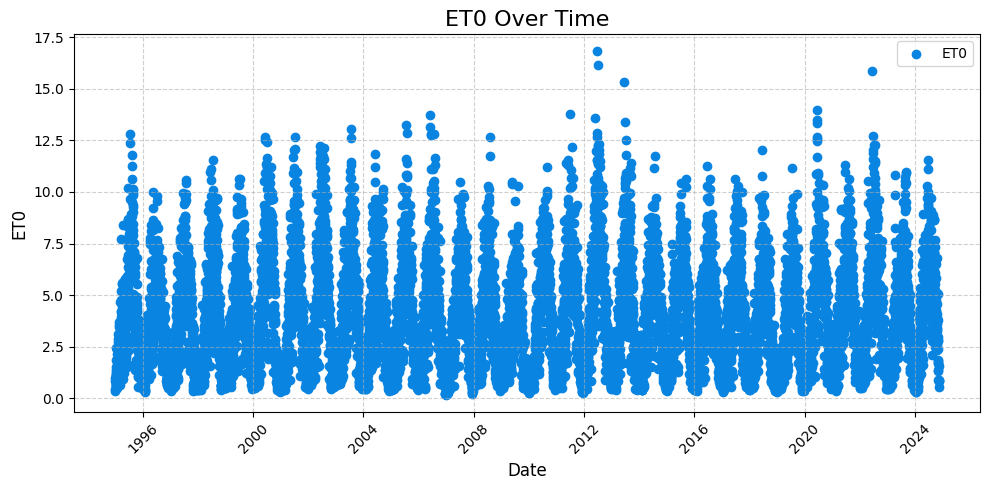

In [11]:
plt.figure(figsize=(10, 5))
plt.scatter(et['ds'], et['ET0'], marker='o', linestyle='-', color='#0984e1', label='ET0')
plt.title("ET0 Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("ET0", fontsize=12)
plt.xticks(rotation=45)

# Add a grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

This plot shows that the time series is very seasonal intuitively. It makes the job easier when it comes to predicting them. We will use a set of different models for this prediction. Here is the list: Prophet, ARIMA, SARIMA. Keep in mind that we will not necessarily go through all of them if it is not necessary.

## Data Preparation

Ths part involves task like feature engineering to be precise globally

In [12]:
from sklearn.impute import KNNImputer

We already identified some NA values in the dataset so we will come up with a solution for them. We use the KNN Imputer here because generally closest days relate to each other in a dataset. This means if yesterday was very large and tomorrow is very low then probably we are somewhere in the middle today (for climate data like Evapotranspiration). That assumption is even stronger when we take into account the fact that the time series is very seasonal with the reversed V shape for each year.

In [13]:
imputer = KNNImputer(n_neighbors=5)

et["ET0"] = pd.DataFrame(imputer.fit_transform(et[["ET0"]]), columns=et[["ET0"]].columns)

C:\Users\hp\AppData\Local\Temp\ipykernel_29096\1659484598.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  et["ET0"] = pd.DataFrame(imputer.fit_transform(et[["ET0"]]), columns=et[["ET0"]].columns)


We will not treat here outliers because the certainly are inconvenient for the models but still they are numerous and plays a great role in predicting the water needs of a crop for a given day. These are too important values to be changed in any way.

The dataset is almost clean. We did the big part of cleaning the data when extracting from NASA servers. For further understanding, you should check the code in fetch.py (extern.fetch.py) and dtmaker.py(extern.dash.dt.dtmaker.py)

## Testing stationarity in time series

In [14]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.impute import KNNImputer

In [15]:
imputer = KNNImputer(n_neighbors=5)

et["ET0"] = pd.DataFrame(imputer.fit_transform(et[["ET0"]]), columns=et[["ET0"]].columns)

C:\Users\hp\AppData\Local\Temp\ipykernel_32188\1659484598.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  et["ET0"] = pd.DataFrame(imputer.fit_transform(et[["ET0"]]), columns=et[["ET0"]].columns)


In [16]:
et.head()

,ds,ET0
0,1995-01-01,1.001230
1,1995-01-02,0.819602
2,1995-01-03,0.438753
3,1995-01-04,0.344787
4,1995-01-05,0.661706


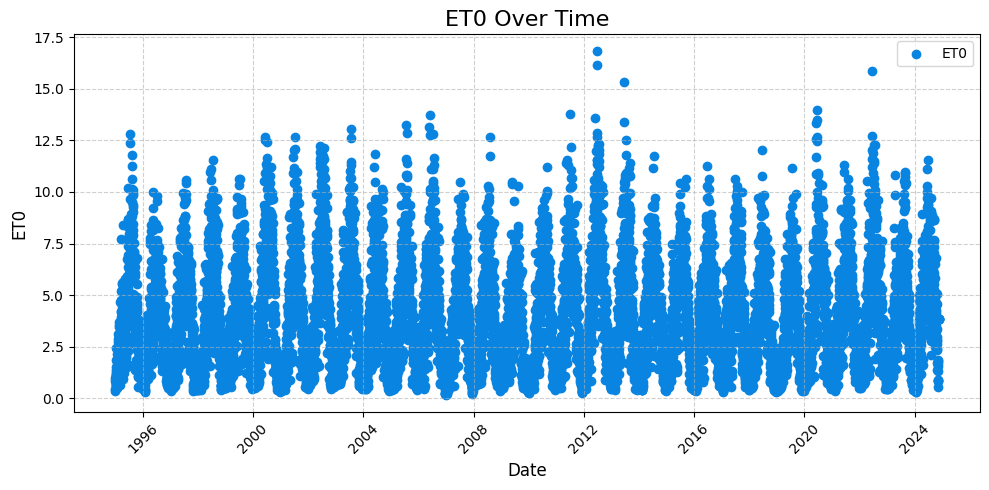

In [17]:
plt.figure(figsize=(10, 5))
plt.scatter(et['ds'], et['ET0'], marker='o', linestyle='-', color='#0984e1', label='ET0')
plt.title("ET0 Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("ET0", fontsize=12)
plt.xticks(rotation=45)

# Add a grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [18]:
def adf_test(timeseries):
  #Perform Dickey-Fuller test:
  print ('Results of Dickey-Fuller Test:')
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

#apply adf test on the series
adf_test(et['ET0'])

Results of Dickey-Fuller Test:
Test Statistic                -6.586395e+00
p-value                        7.296520e-09
#Lags Used                     2.900000e+01
Number of Observations Used    1.088500e+04
Critical Value (1%)           -3.430951e+00
Critical Value (5%)           -2.861806e+00
Critical Value (10%)          -2.566911e+00
dtype: float64


This Dicker-Fuller test shows that the time series ET0 in stationary at a 1% confidence level (p-value < 0.05)

In [19]:
def kpss_test(timeseries):
  print ('Results of KPSS Test:')
  kpsstest = kpss(timeseries, regression='c')
  kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
  for key,value in kpsstest[3].items():
    kpss_output['Critical Value (%s)'%key] = value
  print(kpss_output)

kpss_test(et['ET0'])

Results of KPSS Test:
Test Statistic            0.033997
p-value                   0.100000
Lags Used                58.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\hp\AppData\Local\Temp\ipykernel_32188\1189158974.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c')


The KPSS test shows the opposite (p-value > 0.05). The time series is not stationary. As the two viewed tests are telling not the same thing, we should look to the ACF plot for precision

In [20]:
from statsmodels.graphics.tsaplots import plot_acf

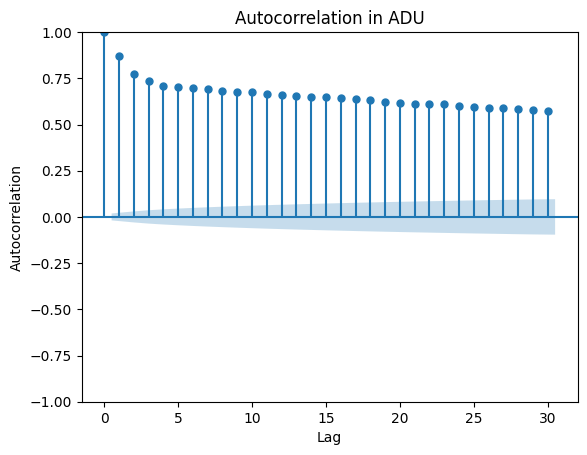

In [21]:
plot_acf(et['ET0'].dropna(), lags=30)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation in ADU')
plt.show()

This ACF plot tells that there is a problem of stationarity in the time series. This rejects the already tested assumption made by the ADF test

In [22]:
etDiff = et.diff().dropna()
etDiff.head()

,ds,ET0
1,1 days,-0.181628
2,1 days,-0.380849
3,1 days,-0.093966
4,1 days,0.316918
5,1 days,-0.017721


DTypePromotionError: The DType <class 'numpy.dtypes.TimeDelta64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.TimeDelta64DType'>, <class 'numpy.dtypes.Float64DType'>)

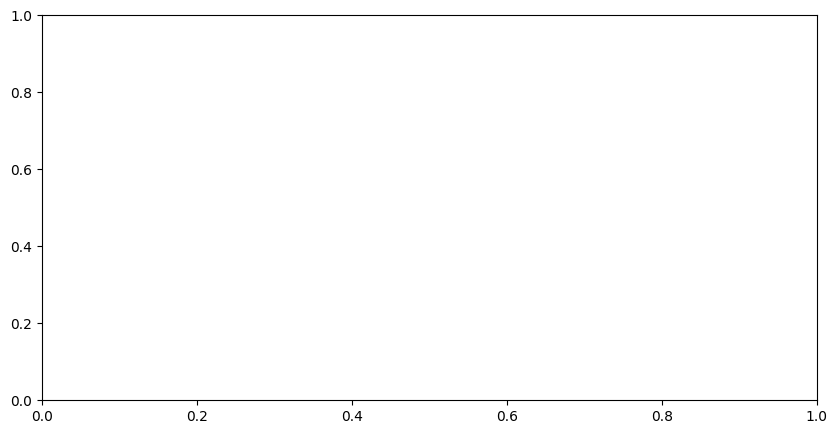

In [23]:
plt.figure(figsize=(10, 5))
plt.scatter(etDiff["ds"], etDiff['ET0'], marker='o', linestyle='-', color='#0984e1', label='ET0')
plt.title("ET0 Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("ET0", fontsize=12)
plt.xticks(rotation=45)

# Add a grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
adf_test(etDiff['ET0'])

Results of Dickey-Fuller Test:
Test Statistic                   -26.115259
p-value                            0.000000
#Lags Used                        28.000000
Number of Observations Used    10885.000000
Critical Value (1%)               -3.430951
Critical Value (5%)               -2.861806
Critical Value (10%)              -2.566911
dtype: float64


In [ ]:
kpss_test(etDiff['ET0'])

Results of KPSS Test:
Test Statistic             0.01819
p-value                    0.10000
Lags Used                278.00000
Critical Value (10%)       0.34700
Critical Value (5%)        0.46300
Critical Value (2.5%)      0.57400
Critical Value (1%)        0.73900
dtype: float64


C:\Users\hp\AppData\Local\Temp\ipykernel_32964\1189158974.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c')


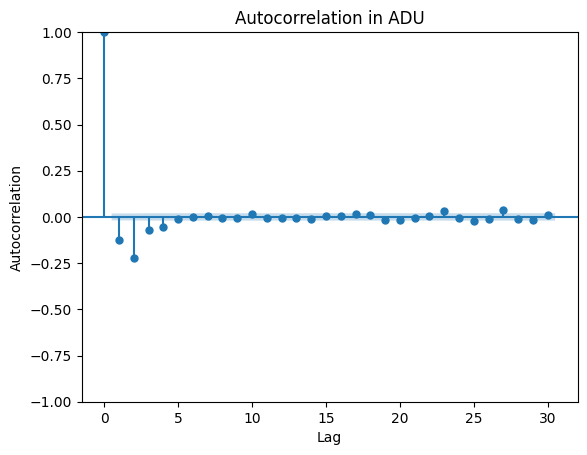

In [ ]:
plot_acf(etDiff['ET0'].dropna(), lags=30)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation in ADU')
plt.show()

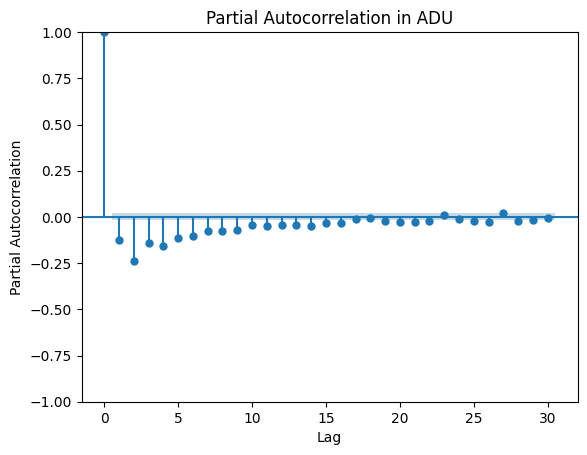

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(etDiff['ET0'].dropna(), lags=30)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation in ADU')
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

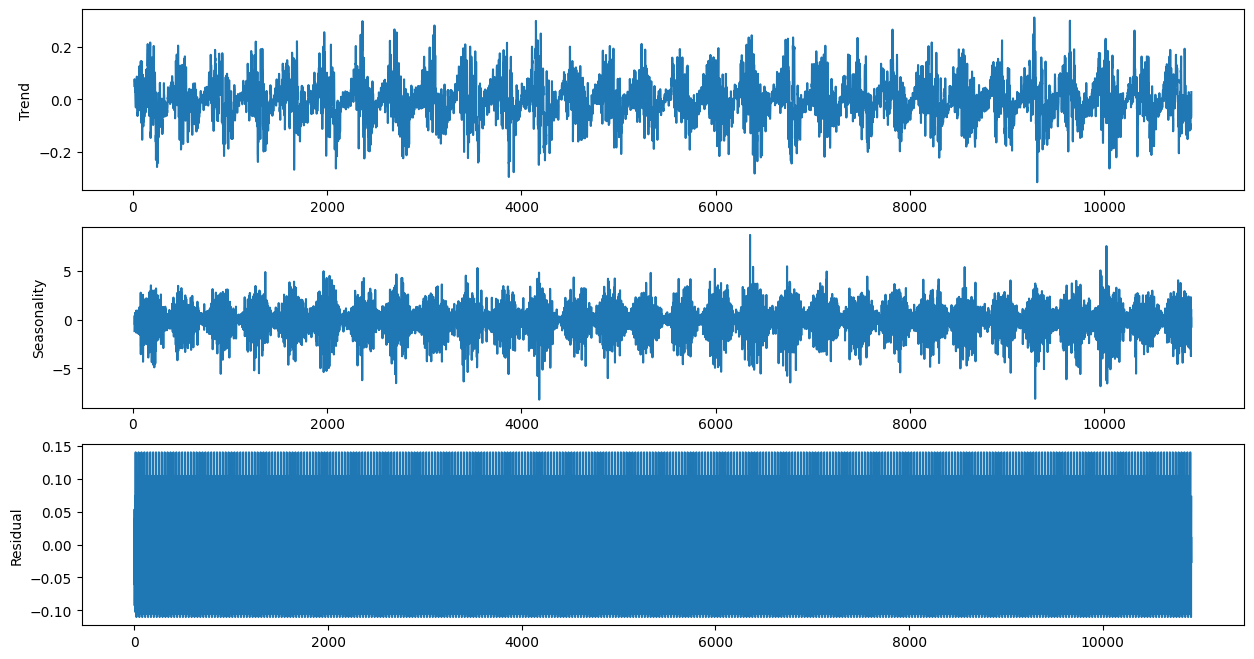

In [ ]:
res = seasonal_decompose(etDiff['ET0'].dropna(), model='additive', period=30)
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "Trend")
res.resid.plot(ax=ax2,ylabel = "Seasonality")
res.seasonal.plot(ax=ax3,ylabel = "Residual")
plt.show()

## Actual models

### Prophet model

#### Feature engineering

We will not call this part feature engineering properly speaking but it does stand for it. Actually, what we are trying to do is rename et dataframe columns after Prophet columns naming convention. So we should have a 'ds' column (for the dates) and a 'y' column (for the target variable).

In [14]:
# etDiff.rename(columns={"ET0": 'y'}, inplace=True)
et.rename(columns={"ET0": 'y'}, inplace=True)

C:\Users\hp\AppData\Local\Temp\ipykernel_29096\3928756730.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  et.rename(columns={"ET0": 'y'}, inplace=True)


In [15]:
et.head()

,ds,y
0,1995-01-01,1.001230
1,1995-01-02,0.819602
2,1995-01-03,0.438753
3,1995-01-04,0.344787
4,1995-01-05,0.661706


We then have to split our dataset into a training set and testing set for the model. We choose the split date as 2018-01-01 and that is completely arbitrary. We could do it another way like taking the first 80% values for train and the remaining part for test or something like that. It would work too. But something that should be kept in mind is that we have to take continuously the first dates for train and the last dates for test, no matter what. Because, time plays an important role here. We can't just shuffle things up for prediction.

In [16]:
split_date = '2018-01-01'
train = et.loc[et["ds"] <= split_date].copy()
test = et.loc[et["ds"] > split_date].copy()

In [17]:
train.tail()

,ds,y
8397,2017-12-28,0.695026
8398,2017-12-29,1.115250
8399,2017-12-30,0.516545
8400,2017-12-31,0.410884
8401,2018-01-01,0.438359


We then create the model. We choose here a simple one. We do not go through all the complex attributes of the Prophet class. What is necessary is just the fact that growth of our time series in flat (empirically from the graph and the seasonality is additive because it doesn't go up too much through the time going by).
We train the model and test it on the test set

In [18]:
model = Prophet(growth="flat", seasonality_mode = 'additive')

In [19]:
model.fit(train)

11:23:36 - cmdstanpy - INFO - Chain [1] start processing
11:23:37 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
test_fcst = model.predict(test)

In [21]:
test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-02,3.847538,-0.922955,3.258731,3.847538,3.847538,-2.794721,-2.794721,-2.794721,0.046264,0.046264,0.046264,-2.840985,-2.840985,-2.840985,0.0,0.0,0.0,1.052817
1,2018-01-03,3.847538,-0.986218,2.971840,3.847538,3.847538,-2.822714,-2.822714,-2.822714,0.010404,0.010404,0.010404,-2.833118,-2.833118,-2.833118,0.0,0.0,0.0,1.024824
2,2018-01-04,3.847538,-0.920404,2.937506,3.847538,3.847538,-2.881446,-2.881446,-2.881446,-0.058201,-0.058201,-0.058201,-2.823245,-2.823245,-2.823245,0.0,0.0,0.0,0.966092
3,2018-01-05,3.847538,-0.843814,2.929860,3.847538,3.847538,-2.863682,-2.863682,-2.863682,-0.052244,-0.052244,-0.052244,-2.811437,-2.811437,-2.811437,0.0,0.0,0.0,0.983856
4,2018-01-06,3.847538,-1.027638,3.029331,3.847538,3.847538,-2.779686,-2.779686,-2.779686,0.018124,0.018124,0.018124,-2.797810,-2.797810,-2.797810,0.0,0.0,0.0,1.067852


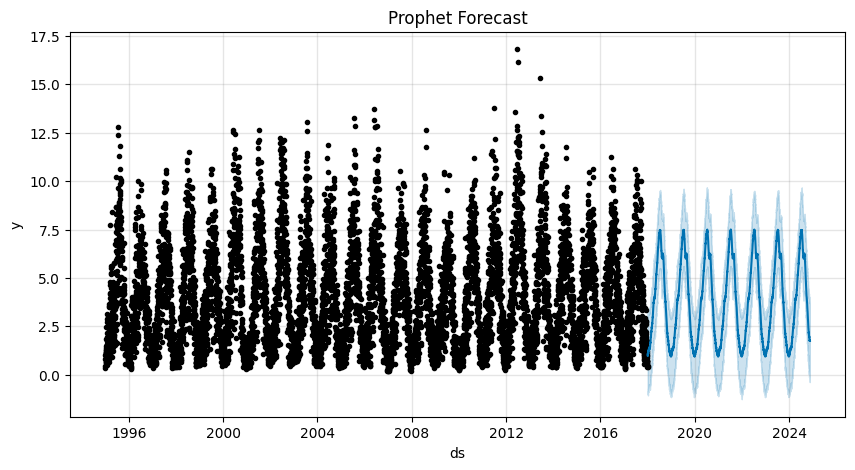

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

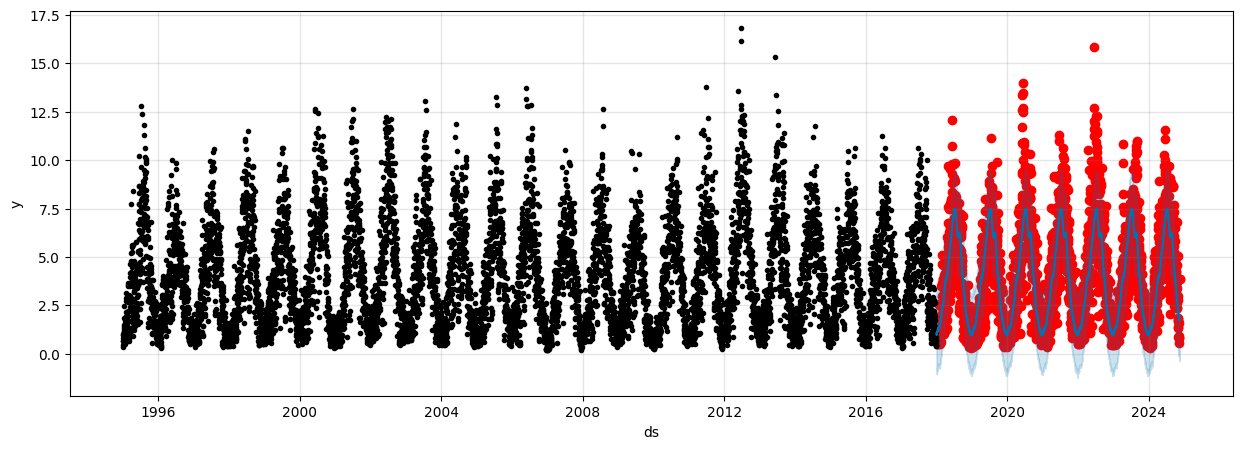

In [23]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test['ds'], test['y'], color='r')
fig = model.plot(test_fcst, ax=ax)

These graphs are good but not quite satisfying as the predicted values don't cover all the data up to the top. We will explore more models for comparison purpose. Hopefully we will get a good one

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [25]:
np.sqrt(mean_squared_error(y_true=test['y'],
                   y_pred=test_fcst['yhat']))

np.float64(1.5600246121690375)

In [26]:
100*(1 - mean_absolute_percentage_error(y_true=test['y'], y_pred=test_fcst['yhat']))

np.float64(58.37113511429999)

We do realise it more when we see that the accuracy is 58% through the test set

### ARIMA model

In [27]:
split_date = '2023-01-01'
train = et.loc[et["ds"] <= split_date].copy()
test = et.loc[et["ds"] > split_date].copy()

For the ARIMA model, on of the most important step is the parameter selection (p, d and q). We will use the grid search to search to explore different combinations of parameters

In [28]:
import itertools
import statsmodels

In [29]:
p = d = q = range(0, 5)
pdq = list(itertools.product(p, d, q))

In [30]:
# seasonal_pdq = [(x[0], x[1], x[2], 365) for x in pdq]

In [31]:
import warnings

import statsmodels.tsa
import statsmodels.tsa.statespace
import statsmodels.tsa.statespace.sarimax

In [51]:
warnings.filterwarnings('ignore')

for param in pdq:
    train_h = train.copy()
    train_h['ds'] = pd.to_datetime(train_h['ds'])
    train_h.set_index('ds', inplace=True)  
    model = statsmodels.tsa.statespace.sarimax.SARIMAX(
        train_h,
        order = param,
        enforce_stationarity = False,
        enforce_invertibility = False
    )
    result = model.fit()
    print(f'ARIMA {param} - AIC: {result.aic}')

ARIMA (0, 0, 0) - AIC: 60542.41281901726
ARIMA (0, 0, 1) - AIC: 50100.964021988315
ARIMA (0, 0, 2) - AIC: 44839.85842301475
ARIMA (0, 0, 3) - AIC: 41932.92305102495
ARIMA (0, 0, 4) - AIC: 40184.54004133145
ARIMA (0, 1, 0) - AIC: 34981.10872072933
ARIMA (0, 1, 1) - AIC: 34658.4794642536
ARIMA (0, 1, 2) - AIC: 33428.95060230082
ARIMA (0, 1, 3) - AIC: 33240.93190180124
ARIMA (0, 1, 4) - AIC: 33190.88886989601
ARIMA (0, 2, 0) - AIC: 43242.68808522046
ARIMA (0, 2, 1) - AIC: 34986.39594453967
ARIMA (0, 2, 2) - AIC: 34664.052582044635
ARIMA (0, 2, 3) - AIC: 33437.01511148806
ARIMA (0, 2, 4) - AIC: 33248.934047583985
ARIMA (0, 3, 0) - AIC: 54162.19407529732
ARIMA (0, 3, 1) - AIC: 43246.32232228516
ARIMA (0, 3, 2) - AIC: 35071.58365604864
ARIMA (0, 3, 3) - AIC: 36515.93569648321
ARIMA (0, 3, 4) - AIC: 36065.68935318128
ARIMA (0, 4, 0) - AIC: 66162.23765988988
ARIMA (0, 4, 1) - AIC: 54163.68522759544
ARIMA (0, 4, 2) - AIC: 43259.6381997416
ARIMA (0, 4, 3) - AIC: 35097.4036010218
ARIMA (0, 4, 4) 

KeyboardInterrupt: 

The best ARIMA model is thus ARIMA (1, 1, 1) x (0, 0, 1, 12) - AIC: 27273.96919019623

We now go on and fit that model and see the results

In [34]:
train_h = train.copy()
train_h['ds'] = pd.to_datetime(train_h['ds'])
train_h.set_index('ds', inplace=True)

In [35]:
best_model = statsmodels.tsa.statespace.sarimax.SARIMAX(
    train_h,
    order = (1, 3, 3),
    enforce_stationarity = False,
    enforce_invertibility = False
)

result = best_model.fit()

e:\SAMS\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
e:\SAMS\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [36]:
print(result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7163      0.272     -2.630      0.009      -1.250      -0.183
ma.L1         -1.2731      0.269     -4.730      0.000      -1.801      -0.746
ma.L2         -0.4517      0.538     -0.839      0.401      -1.506       0.603
ma.L3          0.7262      0.269      2.697      0.007       0.198       1.254
sigma2         1.7998      0.020     89.114      0.000       1.760       1.839


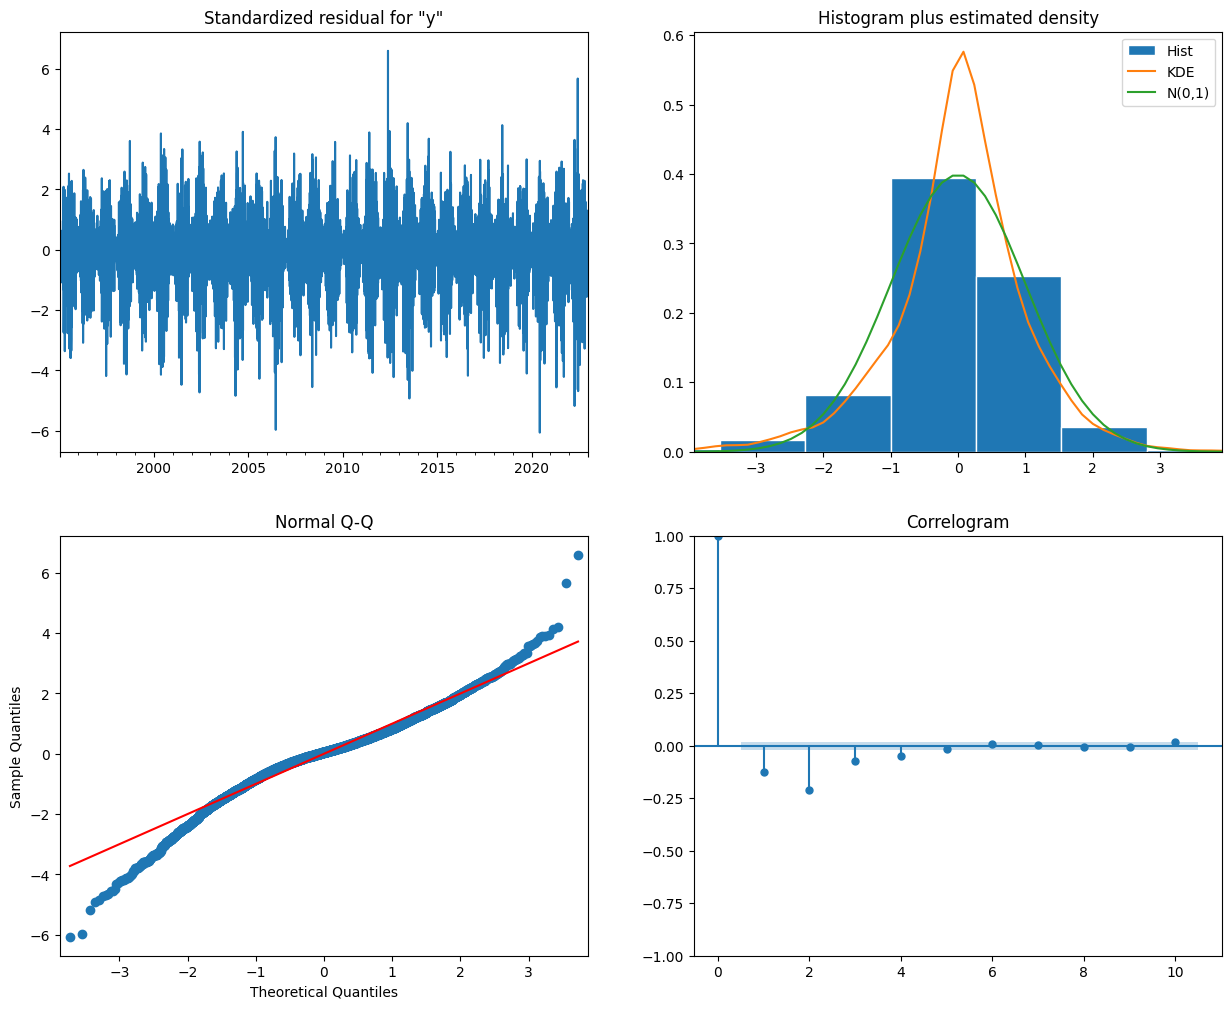

In [37]:
result.plot_diagnostics(figsize=(15, 12))
plt.show()

In [38]:
test_h = test.copy()
test_h['ds'] = pd.to_datetime(test_h['ds'])
test_h.set_index('ds', inplace=True)

In [39]:
predictions = result.forecast(steps=len(test_h))

In [40]:
forecast_obj = result.get_forecast(steps=len(test_h))
predictions = forecast_obj.predicted_mean
confidence_intervals = forecast_obj.conf_int()

In [41]:
confidence_intervals

,lower y,upper y
2023-01-02,-2.060099,3.199851
2023-01-03,-3.166660,4.313246
2023-01-04,-4.009856,5.152430
2023-01-05,-4.727566,5.873544
2023-01-06,-5.361441,6.505159
...,...,...
2024-11-14,-5749.934410,5703.677383
2024-11-15,-5770.821615,5724.424744
2024-11-16,-5791.754484,5745.217561
2024-11-17,-5812.733049,5766.055869


In [42]:
test_h['predicted'] = predictions.values

In [43]:
test_h.head(100)

,y,predicted
ds,,
2023-01-02,0.447965,0.569876
2023-01-03,0.687276,0.573293
2023-01-04,0.929249,0.571287
2023-01-05,1.158668,0.572989
2023-01-06,0.847959,0.571859
...,...,...
2023-04-07,5.960271,0.141982
2023-04-08,8.273943,0.132515
2023-04-09,4.548416,0.122946


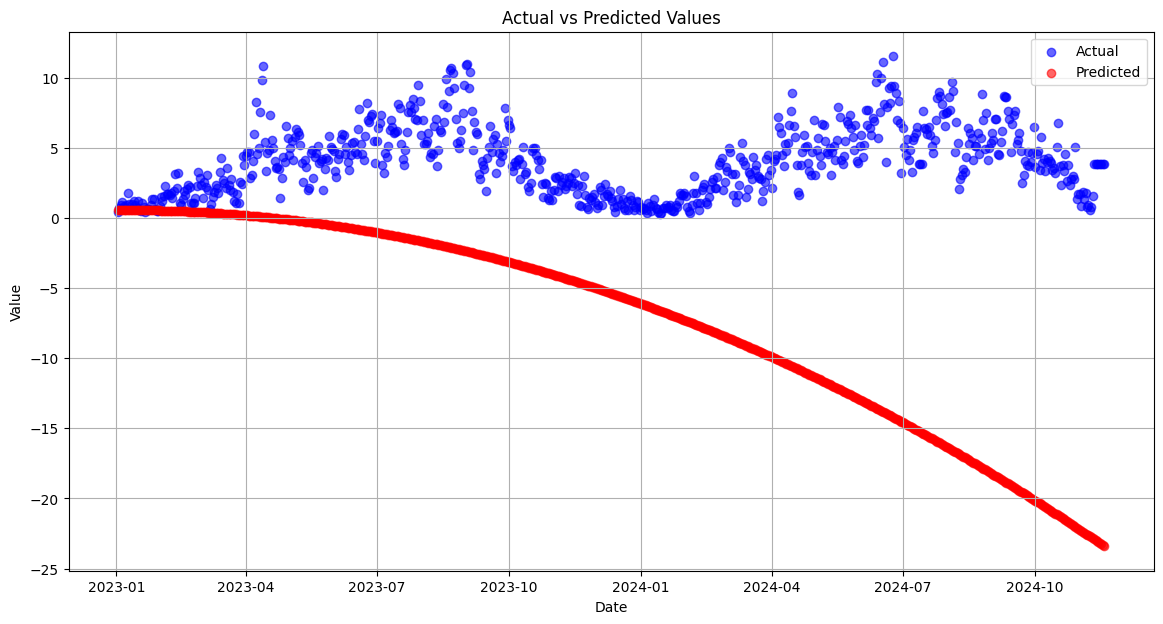

In [44]:
plt.figure(figsize=(14, 7))
plt.scatter(test_h.index, test_h['y'], color='blue', label='Actual', alpha=0.6)
plt.scatter(test_h.index, test_h['predicted'], color='red', label='Predicted', alpha=0.6)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)

plt.show()

# Predicting ALLSKY_SFC_SW_DWN

In [184]:
allsky_sfc_sw_dwn = data_rad[["ds","ALLSKY_SFC_SW_DWN"]]
allsky_sfc_sw_dwn.head()

,ds,ALLSKY_SFC_SW_DWN
0,1995-01-01,7.75
1,1995-01-02,5.94
2,1995-01-03,8.19
3,1995-01-04,8.04
4,1995-01-05,3.78


In [185]:
imputer = KNNImputer(n_neighbors=5)

allsky_sfc_sw_dwn["ALLSKY_SFC_SW_DWN"] = pd.DataFrame(imputer.fit_transform(allsky_sfc_sw_dwn[["ALLSKY_SFC_SW_DWN"]]), columns=allsky_sfc_sw_dwn[["ALLSKY_SFC_SW_DWN"]].columns)

C:\Users\hp\AppData\Local\Temp\ipykernel_32964\6724568.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allsky_sfc_sw_dwn["ALLSKY_SFC_SW_DWN"] = pd.DataFrame(imputer.fit_transform(allsky_sfc_sw_dwn[["ALLSKY_SFC_SW_DWN"]]), columns=allsky_sfc_sw_dwn[["ALLSKY_SFC_SW_DWN"]].columns)


In [190]:
allsky_sfc_sw_dwn.rename(columns={"ALLSKY_SFC_SW_DWN": 'y'}, inplace=True)

C:\Users\hp\AppData\Local\Temp\ipykernel_32964\3429571636.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allsky_sfc_sw_dwn.rename(columns={"ALLSKY_SFC_SW_DWN": 'y'}, inplace=True)


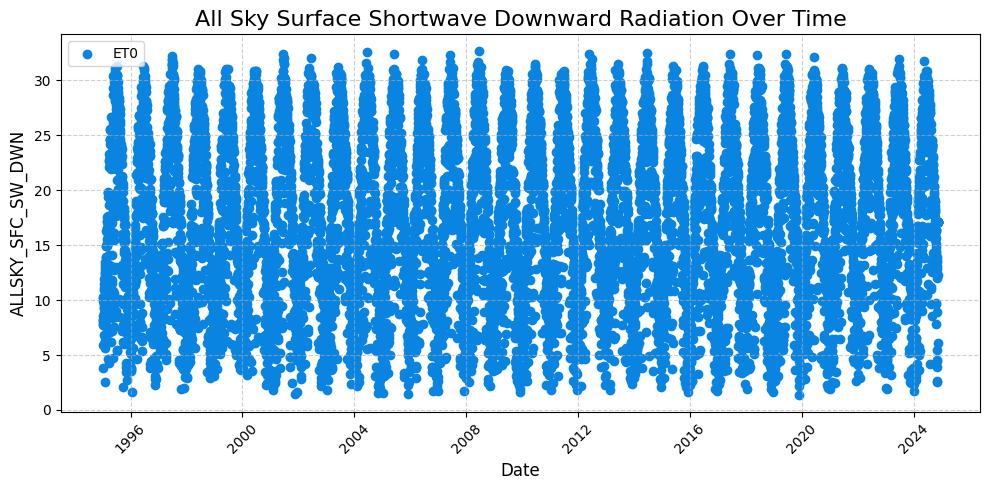

In [192]:
plt.figure(figsize=(10, 5))
plt.scatter(allsky_sfc_sw_dwn['ds'], allsky_sfc_sw_dwn['y'], marker='o', linestyle='-', color='#0984e1', label='ET0')
plt.title("All Sky Surface Shortwave Downward Radiation Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("ALLSKY_SFC_SW_DWN", fontsize=12)
plt.xticks(rotation=45)

# Add a grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [199]:
train = allsky_sfc_sw_dwn.loc[allsky_sfc_sw_dwn["ds"] <= split_date].copy()
test = allsky_sfc_sw_dwn.loc[allsky_sfc_sw_dwn["ds"] > split_date].copy()

In [202]:
model_allsky_sfc_sw_dwn = Prophet(growth="flat", seasonality_mode = 'additive')

In [203]:
model_allsky_sfc_sw_dwn.fit(train)

11:53:15 - cmdstanpy - INFO - Chain [1] start processing
11:53:15 - cmdstanpy - INFO - Chain [1] done processing


In [204]:
test_fcst = model_allsky_sfc_sw_dwn.predict(test)

In [205]:
test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-02,17.031457,2.083937,14.635947,17.031457,17.031457,-8.906855,-8.906855,-8.906855,0.152715,0.152715,0.152715,-9.059570,-9.059570,-9.059570,0.0,0.0,0.0,8.124602
1,2018-01-03,17.031457,1.691951,14.147593,17.031457,17.031457,-9.063405,-9.063405,-9.063405,-0.075122,-0.075122,-0.075122,-8.988283,-8.988283,-8.988283,0.0,0.0,0.0,7.968051
2,2018-01-04,17.031457,2.317445,14.355333,17.031457,17.031457,-9.020928,-9.020928,-9.020928,-0.108750,-0.108750,-0.108750,-8.912178,-8.912178,-8.912178,0.0,0.0,0.0,8.010529
3,2018-01-05,17.031457,2.274405,14.675231,17.031457,17.031457,-8.862997,-8.862997,-8.862997,-0.030977,-0.030977,-0.030977,-8.832020,-8.832020,-8.832020,0.0,0.0,0.0,8.168460
4,2018-01-06,17.031457,2.236388,15.123870,17.031457,17.031457,-8.718944,-8.718944,-8.718944,0.029696,0.029696,0.029696,-8.748640,-8.748640,-8.748640,0.0,0.0,0.0,8.312512


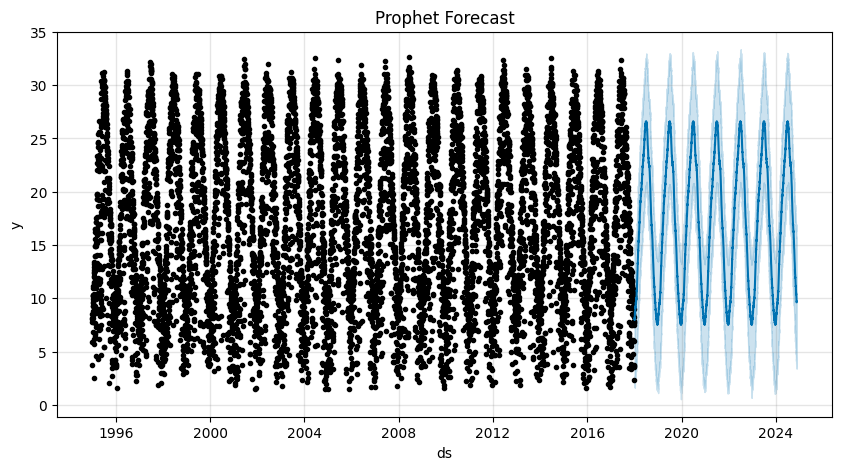

In [206]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model_allsky_sfc_sw_dwn.plot(test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

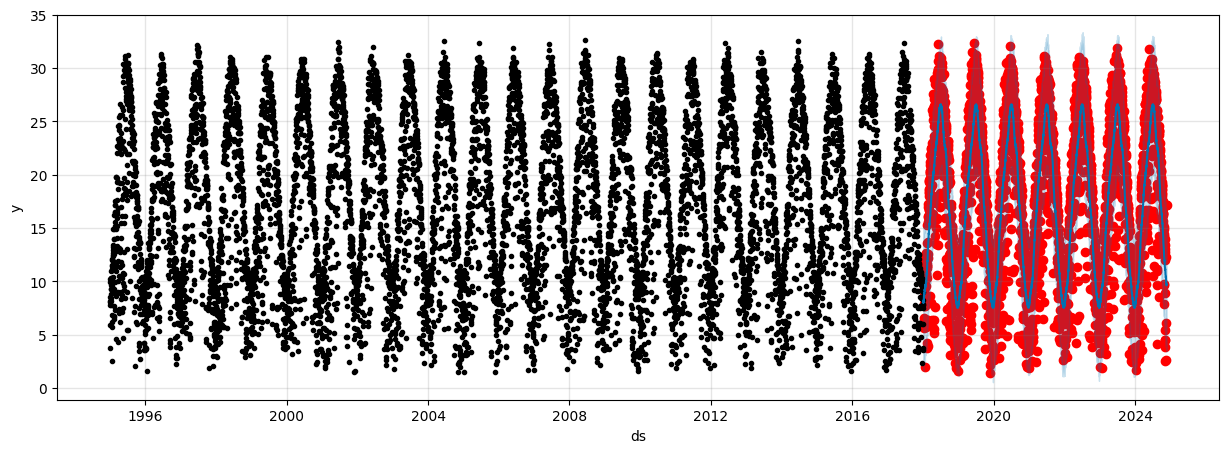

In [208]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test['ds'], test['y'], color='r')
fig = model_allsky_sfc_sw_dwn.plot(test_fcst, ax=ax)

# Predicting WS2M

In [209]:
ws2m = data_rad[["ds","WS2M"]]
ws2m.head()

,ds,WS2M
0,1995-01-01,3.55
1,1995-01-02,2.45
2,1995-01-03,2.18
3,1995-01-04,2.59
4,1995-01-05,5.77


In [210]:
imputer = KNNImputer(n_neighbors=5)

ws2m["WS2M"] = pd.DataFrame(imputer.fit_transform(ws2m[["WS2M"]]), columns=ws2m[["WS2M"]].columns)

C:\Users\hp\AppData\Local\Temp\ipykernel_32964\4222446561.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ws2m["WS2M"] = pd.DataFrame(imputer.fit_transform(ws2m[["WS2M"]]), columns=ws2m[["WS2M"]].columns)


In [211]:
ws2m.rename(columns={"WS2M": 'y'}, inplace=True)

C:\Users\hp\AppData\Local\Temp\ipykernel_32964\3044888552.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ws2m.rename(columns={"WS2M": 'y'}, inplace=True)


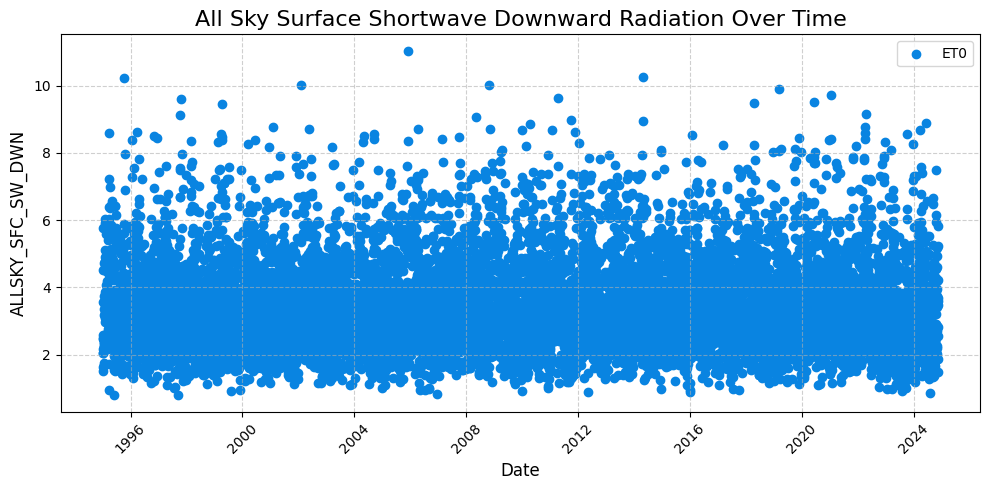

In [212]:
plt.figure(figsize=(10, 5))
plt.scatter(ws2m['ds'], ws2m['y'], marker='o', linestyle='-', color='#0984e1', label='ET0')
plt.title("All Sky Surface Shortwave Downward Radiation Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("ALLSKY_SFC_SW_DWN", fontsize=12)
plt.xticks(rotation=45)

# Add a grid and legend
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()